In [72]:
### MINI PROJEKT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
from IPython.core.pylabtools import figsize
import sklearn.model_selection as skl_ms
import sklearn.metrics as skl_met
import itertools
import math

In [78]:
url = 'train.csv'
dataset = pd.read_csv(url, na_values='?', dtype={'ID': str}).dropna().reset_index()
dataset

,index,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,Lead
0,0,1512,6394,2251.0,343,2,1995,5,2631,142.0,51.500000,42.333333,46.0,65.0,Female
1,1,1524,8780,2020.0,1219,9,2001,4,5236,37.0,39.125000,29.333333,58.0,34.0,Male
2,2,155,4176,942.0,787,7,1968,1,3079,376.0,42.500000,37.000000,46.0,37.0,Male
3,3,1073,9855,3440.0,2623,12,2002,2,5342,19.0,35.222222,21.500000,33.0,23.0,Male
4,4,1317,7688,3835.0,3149,8,1988,4,2536,40.0,45.250000,45.000000,36.0,39.0,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,1034,303,2398,1334.0,1166,5,1973,2,761,174.0,43.200000,31.000000,46.0,24.0,Male
1035,1035,632,8404,1952.0,187,6,1992,2,5820,172.0,37.166667,24.000000,21.0,34.0,Female
1036,1036,1326,2750,877.0,356,2,2000,3,547,53.0,27.500000,27.666667,28.0,25.0,Male
1037,1037,462,3994,775.0,52,8,1996,3,2757,32.0,42.857143,38.500000,29.0,32.0,Female


In [4]:
## Functions
##

def pre_process(raw_data):
    data = raw_data.copy()
    
    data['Lead'] = pd.get_dummies(data['Lead'])
    data['Number of words co-lead'] = data['Number of words lead'] - data['Difference in words lead and co-lead']
    data['Proportion of words lead'] = data['Number of words lead']/data['Total words']
    data['Proportion of words co-lead'] = data['Number of words co-lead']/data['Total words']
    data['Ratio words co-lead lead'] = data['Number of words co-lead']/data['Number of words lead']
    data['Proportion of words female'] = data['Number words female']/(data['Total words'] - data['Number of words lead'])
    data['Proportion of female actors'] = data['Number of female actors']/(data['Number of male actors'] + data['Number of female actors'])
    data['Older lead'] = data['Age Lead'] < data['Age Co-Lead']
    data['Older lead'] = pd.get_dummies(data['Older lead'])
    data['Number of actors'] = data['Number of male actors'] + data['Number of female actors']
     
    return data

def fit_and_test(classifier, train, test, features, target, suppress_output = False):
    classifier.fit(train[features], train[target])
    if not suppress_output:
        skl_met.plot_roc_curve(classifier, test[features], test[target])
        print('accuracy: ' + str(classifier.score(test[features], test[target])))
        print('     auc: ' + str(skl_met.roc_auc_score(test[target], classifier.predict_proba(test[features])[:,1])) + '\n')
        print(skl_met.classification_report(test[target], classifier.predict(test[features])))
    return classifier

Model accuracy for model QuadraticDiscriminantAnalysis() is 
0.9470776772247358


<ipython-input-46-b583250f1f9c>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


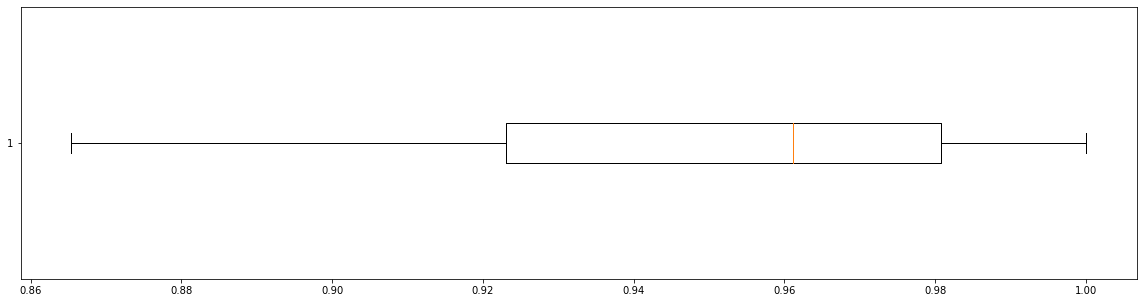

In [46]:
## Accuracy estimation using cross validation to lower variance
##

#X = dataset[dataset.columns[1:14]]
X = pre_process(dataset).drop(columns=['Lead'])
X=X[{
    'Year',
    'Gross',
    'Number of actors',
    'Proportion of female actors',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead',
    'Total words',
    'Proportion of words lead',
    'Proportion of words co-lead',
    'Proportion of words female',
    'Older lead'}]

Y = dataset['Lead']
# Split randomized data into training and validation (30% validation)
X_train, X_val, Y_train, Y_val = skl_ms.train_test_split(X,Y, test_size=0.1)
# List of models
models = []
#models.append(skl_lm.LogisticRegression(solver='liblinear'))
#models.append(skl_da.LinearDiscriminantAnalysis())
models.append(skl_da.QuadraticDiscriminantAnalysis())

n_fold=20
accuracy = np.zeros((n_fold, len(models)))
model_accuracy = np.zeros(len(models))
cv = skl_ms.KFold(n_splits=n_fold, shuffle=True)

for i, (train_index, val_index) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]
    
    for m in range(np.shape(models)[0]):
        model = models[m]
        model.fit(X_train, Y_train)
        prediction = model.predict(X_val)
        accuracy[i,m] = np.mean(prediction == Y_val)
        model_accuracy[m] += accuracy[i,m]
for m in range(np.shape(models)[0]):
    print('Model accuracy for model ' + str(models[m]) + ' is ')
    print(model_accuracy[m]/n_fold)     

plot = plt.figure(figsize=(20,5))
ax = plot.add_subplot(111)
bp = ax.boxplot(accuracy, vert=False)
plot.show()



In [63]:
## Used to compare effects on accuracy of dropping inputs
##

#X = dataset.drop(columns=['Lead'])
#X = pre_process(dataset).drop(columns=['Lead', 'index'])
X = pre_process(dataset).drop(columns=['Lead', 'Difference in words lead and co-lead','Number of female actors','Number of male actors','Number of words co-lead','Number of words lead','Number words female','Number words male','index'])
X2 = pre_process(dataset).drop(columns=['Lead', 'Difference in words lead and co-lead','Number of female actors','Number of male actors','Number of words co-lead','Number of words lead','Number words female','Number words male','index','Ratio words co-lead lead', 'Gross', 'Year'])
Y = dataset['Lead']

# List of models
models = []
#models.append(skl_lm.LogisticRegression(solver='liblinear'))
#models.append(skl_da.LinearDiscriminantAnalysis())
models.append(skl_da.QuadraticDiscriminantAnalysis())

n_fold=200
accuracy = np.zeros((n_fold, len(models)))
accuracy2 = np.zeros((n_fold, len(models)))
model_accuracy = np.zeros(len(models))
model_accuracy2 = np.zeros(len(models))


cv = skl_ms.KFold(n_splits=n_fold, shuffle=True)

for i, (train_index, val_index) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    X2_train, X2_val = X2.iloc[train_index], X2.iloc[val_index]
    Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]
    
    for m in range(np.shape(models)[0]):
        model = models[m]
        model.fit(X_train, Y_train)
        prediction = model.predict(X_val)
        accuracy[i,m] = np.mean(prediction == Y_val)
        model_accuracy[m] += accuracy[i,m]
        
        model.fit(X2_train, Y_train)
        prediction = model.predict(X2_val)
        accuracy[i,m] = np.mean(prediction == Y_val)
        model_accuracy2[m] += accuracy[i,m]

for m in range(np.shape(models)[0]):
    print('Model accuracy change after transformation ' + str(models[m]) + ' is ')
    print((model_accuracy2[m]-model_accuracy[m])/n_fold)

Model accuracy change after transformation QuadraticDiscriminantAnalysis() is 
0.0034999999999999433


In [41]:
## Confusion Matrix
##

#model = skl_da.LinearDiscriminantAnalysis()
model = skl_da.QuadraticDiscriminantAnalysis()

X = pre_process(dataset).drop(columns=['Lead'])
X=X[{
    'Number of actors',
    'Proportion of female actors',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead',
    'Total words',
    'Proportion of words lead',
    'Proportion of words co-lead',
    'Proportion of words female',
    'Older lead'}]

Y = dataset['Lead']
X_train, X_val, Y_train, Y_val = skl_ms.train_test_split(X,Y, test_size=0.3)

model.fit(X_train, Y_train)
predict_prob = model.predict_proba(X_val)
prediction = np.empty(len(X_val), dtype=object)
prediction = np.where(predict_prob[:,0]>1/2, 'Female', 'Male')

print("Confusion matrix: \n")

print(pd.crosstab(prediction, Y_val), '\n')

Confusion matrix: 

Lead    Female  Male
row_0               
Female      75    11
Male         9   217 



In [68]:
## Bootstrapping
##
classifier = skl_da.LinearDiscriminantAnalysis()
features = [
    'Number of actors',
    'Proportion of female actors',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead',
    'Total words',
    'Proportion of words lead',
    'Proportion of words co-lead',
    'Proportion of words female',
    'Older lead',
]
target = 'Lead'
X = pre_process(dataset)
X=X[{
    'Number of actors',
    'Proportion of female actors',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead',
    'Total words',
    'Proportion of words lead',
    'Proportion of words co-lead',
    'Proportion of words female',
    'Older lead', 'Lead'}]
B = 400 # number of training sets to sample
accuracies = []
aucs = []
for i in range(B):
    train, test = skl_ms.train_test_split(X, test_size=0.3)
    QDA = fit_and_test(classifier, train, test, features, target, suppress_output=True)
    accuracies.append(QDA.score(test[features], test[target]))
    aucs.append(skl_met.roc_auc_score(test[target], QDA.predict_proba(test[features])[:,1]))

print('mean accuracy: ' + str(np.mean(accuracies)))
print('     mean auc: ' + str(np.mean(aucs)))

print('     std auc: ' + str(np.std(accuracies)))
print('     std auc: ' + str(np.std(aucs)))

mean accuracy: 0.8990625
     mean auc: 0.9168563739400496
     std auc: 0.01319171888481294
     std auc: 0.01938919275391789


In [61]:
## Used to find optimal combinations of inputs
## 

classifier = skl_da.QuadraticDiscriminantAnalysis()
factors = [
    'Year',
    'Gross',
    'Number of actors',
    'Proportion of female actors',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead',
    'Total words',
    'Proportion of words lead',
    'Proportion of words co-lead',
    'Ratio words co-lead lead',
    'Proportion of words female',
    'Older lead',
]
target = 'Lead'
X = pre_process(dataset).drop(columns=['Difference in words lead and co-lead','Number of female actors','Number of male actors','Number of words co-lead','Number of words lead','Number words female','Number words male','index'])
#for feature in features:
#    X[feature + '2'] = X[feature]**2
#    X[feature + '3'] = X[feature]**3
    
#all_features = features + [feature + '2' for feature in features] + [feature + '3' for feature in features]
max_accuracy = 0
max_auc = 0
best_features_accuracy = {}
best_features_auc = {}
B = 2 #number of bootstrapped training sets
for features in itertools.combinations(factors, len(factors)):
    accuracies = []
    aucs = []
    for i in range(B):
        train, test = skl_ms.train_test_split(X, train_size=0.3)
        QDA = fit_and_test(classifier, train, test, set(features), target, suppress_output=True)
        accuracies.append(QDA.score(test[set(features)], test[target]))
        aucs.append(skl_met.roc_auc_score(test[target], QDA.predict_proba(test[set(features)])[:,1]))
        accuracy = np.mean(accuracies)
        auc = np.mean(aucs)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_features_accuracy = set(features)
    if auc > max_auc:
        max_auc = auc
        best_features_auc = set(features)

print(f'Maximum accuracy: {max_accuracy:.4f}')
print('Best accuracy features', best_features_accuracy)
print(f'Maximum auc: {max_auc:.4f}')
print('Best AUC features', best_features_auc) 
print(set(factors)-set(best_features_accuracy))
print(set(factors)-set(best_features_auc))

Maximum accuracy: 0.9279
Best accuracy features {'Age Lead', 'Older lead', 'Age Co-Lead', 'Proportion of female actors', 'Gross', 'Proportion of words co-lead', 'Proportion of words lead', 'Total words', 'Mean Age Male', 'Number of actors', 'Year', 'Mean Age Female', 'Ratio words co-lead lead', 'Proportion of words female'}
Maximum auc: 0.9631
Best AUC features {'Age Lead', 'Older lead', 'Age Co-Lead', 'Proportion of female actors', 'Gross', 'Proportion of words co-lead', 'Proportion of words lead', 'Total words', 'Mean Age Male', 'Number of actors', 'Year', 'Mean Age Female', 'Ratio words co-lead lead', 'Proportion of words female'}
set()
set()


In [87]:
man = dataset[dataset['Lead']=='Male']
kvinna = dataset[dataset['Lead']=='Female']
print(man.corr()[['Year','Gross']])
print(kvinna.corr()[['Year','Gross']])
#dataset.corr()[[man['Year'], man['Gross']]
#dataset.corr()[[kvinna['Year'], kvinna['Gross']]
#dataset.corr()[['Year', 'Gross']]

                                          Year     Gross
index                                 0.139381 -0.089752
Number words female                   0.010035 -0.115476
Total words                          -0.001107 -0.060318
Number of words lead                  0.011897 -0.116781
Difference in words lead and co-lead  0.017550 -0.100437
Number of male actors                -0.034118  0.114771
Year                                  1.000000 -0.247108
Number of female actors               0.086962 -0.118716
Number words male                    -0.018908  0.052769
Gross                                -0.247108  1.000000
Mean Age Male                         0.054764  0.048568
Mean Age Female                       0.157537 -0.075127
Age Lead                              0.064871 -0.016425
Age Co-Lead                           0.146755 -0.074578
                                          Year     Gross
index                                 0.158640 -0.097605
Number words female            